In [1]:
# !unzip /content/Faces.zip

In [2]:
# !unzip /content/Background.zip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color
import os
from tqdm import tqdm
import joblib
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Preparación de los datos

In [4]:
suffix = '.pgm'

all_files = os.listdir('Faces/')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [5]:
positive_patches = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  positive_patches.append(image)

100%|██████████| 12833/12833 [00:04<00:00, 3041.69it/s]


In [6]:
positive_patches = np.array(positive_patches)
positive_patches.shape

(12833, 64, 64)

In [7]:
P = len(positive_patches)

In [8]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
        img = (img * 255).astype(np.uint8)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
for i in range(31):
    filename = "Background/"+str(i)+".jpg"
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

In [9]:
# Tamaño de las imágenes de rostros
size = positive_patches[0].shape
print(f'Image size: {size}')

Image size: (64, 64)


In [10]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [11]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 40/40 [00:01<00:00, 26.60it/s]


(12800, 64, 64)

In [12]:
N = len(negative_patches)

In [13]:
X = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y = np.zeros(len(X))
y[:P] = 1

Construyendo X: 25633it [00:13, 1970.79it/s]


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape

(20506, 2916)

In [16]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [17]:
# Guardar el scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [18]:
# Apply PCA to extract eigenfaces

pca = PCA(n_components=500, whiten=True).fit(X_train_std)

In [19]:
# Guardar PCA
joblib.dump(pca, 'pca.joblib')

['pca.joblib']

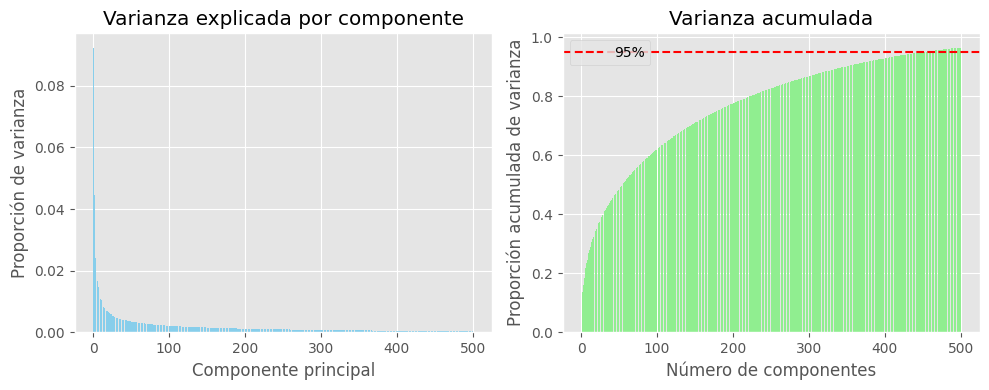

In [20]:
# Obtener varianzas
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Varianza explicada
ax1.bar(range(1, len(var_explicada)+1), var_explicada, color='skyblue')
ax1.set_title('Varianza explicada por componente')
ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Proporción de varianza')
ax1.grid(True)

# Varianza acumulada
ax2.bar(range(1, len(var_acumulada)+1), var_acumulada, color='lightgreen')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax2.set_title('Varianza acumulada')
ax2.set_xlabel('Número de componentes')
ax2.set_ylabel('Proporción acumulada de varianza')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

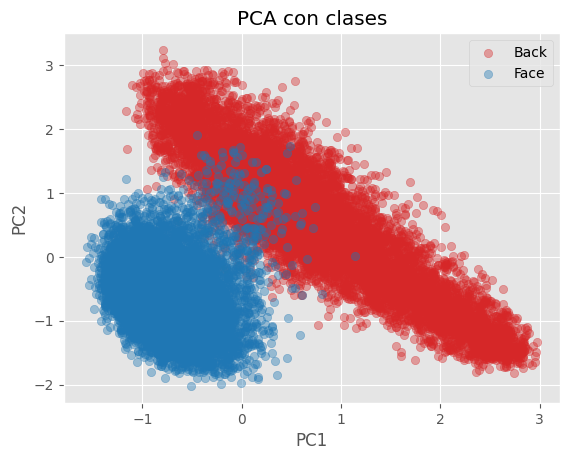

In [21]:
X_train_pca = pca.transform(X_train_std)

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    plt.scatter(X_train_pca[y_train == class_value, 0], X_train_pca[y_train == class_value, 1],
                c=colors[class_value], label=labels[class_value], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

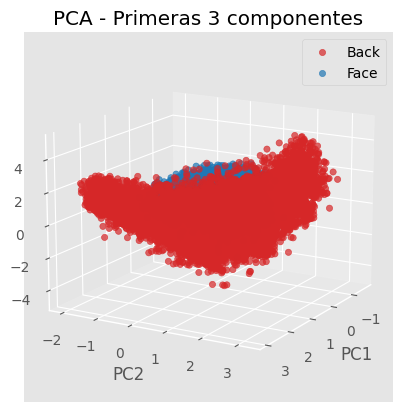

In [22]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    ax.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        X_train_pca[y_train == class_value, 2],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.7
    )

ax.view_init(elev=15, azim=30)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Primeras 3 componentes')
ax.legend()
plt.show()

# Clasificador

In [23]:
model = GaussianNB()

In [24]:
model.fit(X_train_pca, y_train)

GaussianNB()

In [25]:
y_train_pred = model.predict(X_train_pca)

In [26]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     10273
         1.0       0.92      0.94      0.93     10233

    accuracy                           0.93     20506
   macro avg       0.93      0.93      0.93     20506
weighted avg       0.93      0.93      0.93     20506



In [27]:
X_val_std = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_std)

In [28]:
y_val_pred = model.predict(X_val_pca)

In [29]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2527
         1.0       0.93      0.94      0.94      2600

    accuracy                           0.94      5127
   macro avg       0.94      0.94      0.94      5127
weighted avg       0.94      0.94      0.94      5127



In [30]:
# Guardar el modelo
joblib.dump(model, 'modelo_entrenado.joblib')

['modelo_entrenado.joblib']

# Encontrar los mejores hiperparámetros

In [31]:
# pip install optuna

In [38]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [39]:
# Define the objective function for Optuna optimization (GaussianNB only)
def objective(trial):
    # Suggest hyperparameters only for GaussianNB
    var_smoothing = trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    
    # Use the existing PCA transformation (with original parameters: 500 components, whiten=True)
    # We'll use the already fitted PCA from your original model
    
    # Create and train GaussianNB with suggested parameters
    model_trial = GaussianNB(var_smoothing=var_smoothing)
    
    # Use cross-validation to evaluate the model
    # We use the existing X_train_pca (from your original PCA with 500 components)
    cv_scores = cross_val_score(model_trial, X_train_pca, y_train, 
                               cv=5, scoring='f1', n_jobs=-1)
    
    # Return the mean cross-validation score
    return cv_scores.mean()

In [40]:
# Create a study object and optimize
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='maximize')  # We want to maximize F1-score
study.optimize(objective, n_trials=50)  # You can increase n_trials for better results

print("Optimization completed!")
print(f"Best trial: {study.best_trial.number}")
print(f"Best F1-score: {study.best_value:.4f}")
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-06-21 11:25:38,709] A new study created in memory with name: no-name-0056fe6f-0e3d-42ae-b1d3-4022dcdbb781


Starting hyperparameter optimization with Optuna...


[I 2025-06-21 11:25:43,507] Trial 0 finished with value: 0.9312772612273594 and parameters: {'var_smoothing': 2.6770326355876675e-10}. Best is trial 0 with value: 0.9312772612273594.
[I 2025-06-21 11:25:44,470] Trial 1 finished with value: 0.9312772612273594 and parameters: {'var_smoothing': 2.867992972804256e-07}. Best is trial 0 with value: 0.9312772612273594.
[I 2025-06-21 11:25:45,315] Trial 2 finished with value: 0.9312772612273594 and parameters: {'var_smoothing': 1.1732975126589644e-11}. Best is trial 0 with value: 0.9312772612273594.
[I 2025-06-21 11:25:45,757] Trial 3 finished with value: 0.9312772612273594 and parameters: {'var_smoothing': 9.287588192385024e-10}. Best is trial 0 with value: 0.9312772612273594.
[I 2025-06-21 11:25:46,318] Trial 4 finished with value: 0.9312772612273594 and parameters: {'var_smoothing': 8.609651178193416e-10}. Best is trial 0 with value: 0.9312772612273594.
[I 2025-06-21 11:25:46,960] Trial 5 finished with value: 0.9312772612273594 and paramete

Optimization completed!
Best trial: 0
Best F1-score: 0.9313
Best parameters:
  var_smoothing: 2.6770326355876675e-10


In [41]:
# Train the final model with the best parameters
best_params = study.best_params

# Use the existing PCA (no optimization needed for PCA)
# We'll use the original pca object that was already fitted
pca_optimized = pca  # Use the original PCA with 500 components and whiten=True
X_train_pca_optimized = X_train_pca  # Use the existing transformation

# Create and train GaussianNB with best parameters
model_optimized = GaussianNB(var_smoothing=best_params['var_smoothing'])
model_optimized.fit(X_train_pca_optimized, y_train)

print("Optimized GaussianNB model trained successfully!")
print(f"Best var_smoothing parameter: {best_params['var_smoothing']}")


Optimized GaussianNB model trained successfully!
Best var_smoothing parameter: 2.6770326355876675e-10


In [44]:
# Evaluate the optimized model on training data
y_train_pred_optimized = model_optimized.predict(X_train_pca_optimized)
print("========== OPTIMIZED MODEL - TRAINING RESULTS ==========")
print(classification_report(y_train, y_train_pred_optimized))


========== OPTIMIZED MODEL - TRAINING RESULTS ==========
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     10273
         1.0       0.92      0.94      0.93     10233

    accuracy                           0.93     20506
   macro avg       0.93      0.93      0.93     20506
weighted avg       0.93      0.93      0.93     20506



In [37]:
# # Compare original vs optimized model performance
# print("=== PERFORMANCE COMPARISON ===")
# print("\nOriginal Model (Validation):")
# print(f"F1-score: {f1_score(y_val, y_val_pred):.4f}")

# print("\nOptimized Model (Validation):")
# print(f"F1-score: {f1_score(y_val, y_val_pred_optimized):.4f}")

# improvement = f1_score(y_val, y_val_pred_optimized) - f1_score(y_val, y_val_pred)
# print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f}%)")


=== PERFORMANCE COMPARISON ===

Original Model (Validation):
F1-score: 0.9388

Optimized Model (Validation):


NameError: name 'y_val_pred_optimized' is not defined

In [ ]:
# Visualize optimization history
import matplotlib.pyplot as plt

# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot objective values over trials
trials_df = study.trials_dataframe()
ax1.plot(trials_df['number'], trials_df['value'])
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('F1-Score')
ax1.set_title('Optimization Progress')
ax1.grid(True)

# Plot parameter importance (if available)
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    ax2.barh(params, values)
    ax2.set_xlabel('Importance')
    ax2.set_title('Parameter Importance')
    ax2.grid(True)
except:
    ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Parameter Importance')

plt.tight_layout()
plt.show()


In [ ]:
# Save the optimized GaussianNB model
# Note: PCA remains the same as original (500 components, whiten=True)
joblib.dump(model_optimized, 'modelo_gaussianNB_optimizado.joblib')

print("Optimized GaussianNB model saved successfully!")
print(f"- GaussianNB optimized: modelo_gaussianNB_optimizado.joblib")
print(f"- PCA (unchanged): pca.joblib")
print(f"- Scaler (unchanged): scaler.joblib")


In [ ]:
# Evaluate the optimized model on validation data
X_val_pca_optimized = X_val_pca  # Use the existing validation PCA transformation
y_val_pred_optimized = model_optimized.predict(X_val_pca_optimized)

print("=== OPTIMIZED MODEL - VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred_optimized))
y_val_pred_optimized = model_optimized.predict(X_val_pca_optimized)

print("=== OPTIMIZED MODEL - VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred_optimized))


In [ ]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters
    n_components = trial.suggest_int('n_components', 50, 1000, step=50)
    whiten = trial.suggest_categorical('whiten', [True, False])
    var_smoothing = trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    
    # Apply PCA with suggested parameters
    pca_trial = PCA(n_components=n_components, whiten=whiten)
    X_train_pca_trial = pca_trial.fit_transform(X_train_std)
    
    # Create and train GaussianNB with suggested parameters
    model_trial = GaussianNB(var_smoothing=var_smoothing)
    
    # Use cross-validation to evaluate the model
    # We use f1_score as the metric since it's good for binary classification
    cv_scores = cross_val_score(model_trial, X_train_pca_trial, y_train, 
                               cv=5, scoring='f1', n_jobs=-1)
    
    # Return the mean cross-validation score
    return cv_scores.mean()


#######

In [55]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Hyperparameters to optimize
    n_positive_samples = trial.suggest_int('n_positive_samples', 2000, len(positive_patches), step=1000)
    var_smoothing = trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)

    # --- Data Preparation inside the objective ---
    # Select a subset of positive patches
    current_positive_patches = positive_patches[:n_positive_samples]

    # Combine positive and negative patches to form the full dataset
    X_full = np.array([feature.hog(im) for im in chain(current_positive_patches, negative_patches)])
    y_full = np.zeros(len(X_full))
    y_full[:len(current_positive_patches)] = 1

    # Split data into training and validation sets
    X_train_trial, X_val_trial, y_train_trial, y_val_trial = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

    # Scale the features
    scaler_trial = StandardScaler()
    X_train_std_trial = scaler_trial.fit_transform(X_train_trial)

    # Apply PCA (fixed parameters as per previous discussion, n_components=500, whiten=True)
    pca_trial = PCA(n_components=500, whiten=True)
    X_train_pca_trial = pca_trial.fit_transform(X_train_std_trial)
    # --- End Data Preparation ---

    # Create and train GaussianNB with suggested parameters
    model_trial = GaussianNB(var_smoothing=var_smoothing)

    # Use cross-validation to evaluate the model
    cv_scores = cross_val_score(model_trial, X_train_pca_trial, y_train_trial,
                                cv=5, scoring='f1', n_jobs=-1)

    # Return the mean cross-validation score
    return cv_scores.mean()

In [57]:
# Create a study object and optimize
print("Starting hyperparameter optimization with Optuna...")
# We want to maximize the F1-score, so direction='maximize'
study = optuna.create_study(direction='maximize')
# Run the optimization for 50 trials (you can increase this for potentially better results)
study.optimize(objective, n_trials=50, show_progress_bar=True) # show_progress_bar=True added for visual progress

print("\nOptimization completed!")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best F1-score: {study.best_value:.4f}")
print("Best parameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-06-21 12:10:51,181] A new study created in memory with name: no-name-18c6fb2b-4592-4891-adb2-e837b492cd2e


Starting hyperparameter optimization with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:11:25,979] Trial 0 finished with value: 0.9014714977667071 and parameters: {'n_positive_samples': 6000, 'var_smoothing': 3.398268811474363e-11}. Best is trial 0 with value: 0.9014714977667071.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:11:57,521] Trial 1 finished with value: 0.9366797790389529 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 2.4267773915840316e-07}. Best is trial 1 with value: 0.9366797790389529.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:12:24,845] Trial 2 finished with value: 0.9295364272939863 and parameters: {'n_positive_samples': 8000, 'var_smoothing': 4.564879765921618e-11}. Best is trial 1 with value: 0.9366797790389529.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:12:56,907] Trial 3 finished with value: 0.938129010359208 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 8.053695558266663e-12}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:13:20,619] Trial 4 finished with value: 0.8954891786020156 and parameters: {'n_positive_samples': 4000, 'var_smoothing': 3.1213877598435867e-10}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:13:41,340] Trial 5 finished with value: 0.8924729630117675 and parameters: {'n_positive_samples': 2000, 'var_smoothing': 8.450706097783061e-09}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:14:03,640] Trial 6 finished with value: 0.896190970895178 and parameters: {'n_positive_samples': 4000, 'var_smoothing': 8.449664825703902e-08}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:14:33,017] Trial 7 finished with value: 0.9186735685694838 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 1.2016320658807777e-11}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:14:54,474] Trial 8 finished with value: 0.8937593429574054 and parameters: {'n_positive_samples': 3000, 'var_smoothing': 1.2387041940180187e-11}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:15:21,928] Trial 9 finished with value: 0.9181203931118651 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 2.950281968854629e-09}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:15:52,516] Trial 10 finished with value: 0.9380300305855428 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 1.0000955904901297e-12}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:16:22,177] Trial 11 finished with value: 0.93803523929011 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 1.090965883836523e-12}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:16:52,829] Trial 12 finished with value: 0.9378493796928383 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 1.0261699734846599e-12}. Best is trial 3 with value: 0.938129010359208.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:17:22,114] Trial 13 finished with value: 0.9385676184706868 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 2.2769935639848518e-10}. Best is trial 13 with value: 0.9385676184706868.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:17:50,376] Trial 14 finished with value: 0.9367488460429815 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 1.9940488013722337e-10}. Best is trial 13 with value: 0.9385676184706868.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:18:14,333] Trial 15 finished with value: 0.9033185757167941 and parameters: {'n_positive_samples': 6000, 'var_smoothing': 4.827062357048607e-10}. Best is trial 13 with value: 0.9385676184706868.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:18:46,932] Trial 16 finished with value: 0.9380507130530443 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 1.3202571673501623e-08}. Best is trial 13 with value: 0.9385676184706868.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:19:11,936] Trial 17 finished with value: 0.916941515959176 and parameters: {'n_positive_samples': 7000, 'var_smoothing': 6.7393415233346515e-12}. Best is trial 13 with value: 0.9385676184706868.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:19:41,659] Trial 18 finished with value: 0.9386316146087539 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 8.186083209120296e-11}. Best is trial 18 with value: 0.9386316146087539.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:20:09,927] Trial 19 finished with value: 0.9365598264192203 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 1.5567963064426396e-09}. Best is trial 18 with value: 0.9386316146087539.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:20:36,542] Trial 20 finished with value: 0.9294893964942998 and parameters: {'n_positive_samples': 8000, 'var_smoothing': 9.767708997452719e-11}. Best is trial 18 with value: 0.9386316146087539.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:21:05,486] Trial 21 finished with value: 0.9383604023465271 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 4.781942309179098e-12}. Best is trial 18 with value: 0.9386316146087539.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:21:36,753] Trial 22 finished with value: 0.9386720491140697 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 9.672994212805861e-11}. Best is trial 22 with value: 0.9386720491140697.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:22:05,505] Trial 23 finished with value: 0.9385450749949742 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 7.688248368170754e-10}. Best is trial 22 with value: 0.9386720491140697.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:22:32,245] Trial 24 finished with value: 0.9192603883654952 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 8.215537223687127e-11}. Best is trial 22 with value: 0.9386720491140697.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:23:01,561] Trial 25 finished with value: 0.9381398152799518 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 1.7225089354579876e-10}. Best is trial 22 with value: 0.9386720491140697.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:23:28,822] Trial 26 finished with value: 0.935910959734579 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 3.769012459315148e-09}. Best is trial 22 with value: 0.9386720491140697.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:23:54,930] Trial 27 finished with value: 0.9286834005155837 and parameters: {'n_positive_samples': 8000, 'var_smoothing': 3.3888663271637624e-11}. Best is trial 22 with value: 0.9386720491140697.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:24:23,833] Trial 28 finished with value: 0.9390543977236856 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 7.721049939658849e-10}. Best is trial 28 with value: 0.9390543977236856.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:24:49,668] Trial 29 finished with value: 0.9177036484448703 and parameters: {'n_positive_samples': 7000, 'var_smoothing': 2.6704548805871426e-11}. Best is trial 28 with value: 0.9390543977236856.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:25:17,013] Trial 30 finished with value: 0.9184782574885245 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 2.0211069643663407e-08}. Best is trial 28 with value: 0.9390543977236856.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:25:47,775] Trial 31 finished with value: 0.9391109800730204 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 1.1307471390102775e-09}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:26:15,710] Trial 32 finished with value: 0.9358056595523813 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 1.6351647734474372e-09}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:26:47,258] Trial 33 finished with value: 0.9381633757546792 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 6.47239209799455e-10}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:27:15,843] Trial 34 finished with value: 0.9380004810229314 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 9.867005458867572e-11}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:27:44,639] Trial 35 finished with value: 0.9367643332793106 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 3.967363729579786e-09}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:28:14,046] Trial 36 finished with value: 0.9384675405709153 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 3.88874141575767e-07}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:28:40,948] Trial 37 finished with value: 0.9291738918973316 and parameters: {'n_positive_samples': 8000, 'var_smoothing': 7.901238207701347e-08}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:29:03,942] Trial 38 finished with value: 0.9006153565897048 and parameters: {'n_positive_samples': 5000, 'var_smoothing': 3.9352090831416644e-10}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:29:32,029] Trial 39 finished with value: 0.918132678184471 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 1.2963384157304722e-09}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:30:01,634] Trial 40 finished with value: 0.9380430849141698 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 7.120130228055907e-11}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:30:30,295] Trial 41 finished with value: 0.9389129037516097 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 2.6323945635036833e-10}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:30:58,356] Trial 42 finished with value: 0.9362203763989015 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 2.703605581286435e-11}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:31:27,650] Trial 43 finished with value: 0.9388177068646243 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 3.01768037256531e-10}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:31:59,443] Trial 44 finished with value: 0.9379141411793173 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 3.238659022097744e-10}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:32:29,346] Trial 45 finished with value: 0.9376967932771857 and parameters: {'n_positive_samples': 12000, 'var_smoothing': 2.4472773588840044e-09}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:32:57,230] Trial 46 finished with value: 0.9362211616571313 and parameters: {'n_positive_samples': 10000, 'var_smoothing': 5.67330592486376e-09}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:33:25,522] Trial 47 finished with value: 0.9384298278356182 and parameters: {'n_positive_samples': 11000, 'var_smoothing': 8.345779960413384e-10}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:33:45,101] Trial 48 finished with value: 0.892706001044823 and parameters: {'n_positive_samples': 2000, 'var_smoothing': 2.3104192511920133e-10}. Best is trial 31 with value: 0.9391109800730204.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 12:34:11,877] Trial 49 finished with value: 0.9177913511094943 and parameters: {'n_positive_samples': 9000, 'var_smoothing': 1.5304554010329817e-10}. Best is trial 31 with value: 0.9391109800730204.

Optimization completed!
Best trial number: 31
Best F1-score: 0.9391
Best parameters found:
  n_positive_samples: 11000
  var_smoothing: 1.1307471390102775e-09


In [58]:
study.best_params

{'n_positive_samples': 11000, 'var_smoothing': 1.1307471390102775e-09}

In [59]:
# Train the final model with the best parameters
best_params = study.best_params

# Re-prepare the data using the best n_positive_samples
final_n_positive_samples = best_params['n_positive_samples']
final_current_positive_patches = positive_patches[:final_n_positive_samples]

# Combine positive and negative patches to form the full dataset
X_final_full = np.array([feature.hog(im) for im in chain(final_current_positive_patches, negative_patches)])
y_final_full = np.zeros(len(X_final_full))
y_final_full[:len(final_current_positive_patches)] = 1

# Split data into training and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final_full, y_final_full, test_size=0.2, random_state=42)

# Scale the features
scaler_final = StandardScaler()
X_train_std_final = scaler_final.fit_transform(X_train_final)
X_val_std_final = scaler_final.transform(X_val_final) # Scale validation data too

# Apply PCA (fixed parameters: 500 components, whiten=True)
pca_final = PCA(n_components=500, whiten=True)
X_train_pca_final = pca_final.fit_transform(X_train_std_final)
X_val_pca_final = pca_final.transform(X_val_std_final) # Transform validation data

# Create and train GaussianNB with best parameters
model_optimized = GaussianNB(var_smoothing=best_params['var_smoothing'])
model_optimized.fit(X_train_pca_final, y_train_final)

print("Optimized GaussianNB model trained successfully with best parameters!")
print(f"Best n_positive_samples: {best_params['n_positive_samples']}")
print(f"Best var_smoothing parameter: {best_params['var_smoothing']}")

Optimized GaussianNB model trained successfully with best parameters!
Best n_positive_samples: 11000
Best var_smoothing parameter: 1.1307471390102775e-09


In [61]:
os.getcwd()

'/Users/josefina.lin/Documents/GitHub/ORT-AI/ML para AI/Obligatorio'

In [64]:
joblib.dump(scaler_final ,'models/scaler_optuna.joblib')

['models/scaler_optuna.joblib']

In [63]:
joblib.dump(pca_final ,'models/pca_optuna.joblib')

['models/pca_optuna.joblib']

In [62]:
joblib.dump(model_optimized ,'models/GaussianNB_optuna.joblib')

['models/GaussianNB_optuna.joblib']